In [1]:
from collections import deque
from sklearn.feature_extraction import DictVectorizer
import tensorflow as tf
import numpy as np
import xml.etree.ElementTree as et

vowel_table = {"a" : ["á"], "e" : ["é"], "i" : ["í"], "o" : ["ó", "ö", "ő"], "u" : ["ú", "ü", "ű"]}
vectorizer = DictVectorizer()

In [2]:
def ispunct(c):
    punctuations = "!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~"
    for char in punctuations:
        if (c == char):
            return True
    return False


def isalpha(c):
    alphabet = "abcdefghijklmnopqrstuvwxyz"
    for char in alphabet:
        if (c == char):
            return True
    return False

# reduces the number of different characters to 30
def normalize_character(c):
    if (c.isspace()):
        return ' '
    if (c.isdigit()):
        return '0'
    if (ispunct(c)):
        return '_'
    if (isalpha(c)):
        return c
    return '*'


def normalize_text(text):
    normalized = ""
    for c in text:
        normalized += normalize_character(c)
    return normalized

In [3]:
def deaccentize(text):
    text = text.replace("á", "a")
    text = text.replace("é", "e")
    text = text.replace("í", "i")
    text = text.replace("ó", "o")
    text = text.replace("ö", "o")
    text = text.replace("ő", "o")
    text = text.replace("ú", "u")
    text = text.replace("ü", "u")
    text = text.replace("ű", "u")

    return text

def create_row(window, window_size):
    row = {}

    for i in range(-window_size, window_size + 1):
        row[i] = normalize_character(deaccentize(window.popleft()))

    del row[0]

    return row

def get_y(vowel):
    if vowel in "aei":
        return [1, 0]
    if vowel in "áéí":
        return [0, 1]
    if vowel in "ou":
        return [1, 0, 0, 0]
    if vowel in "óú":
        return [0, 1, 0, 0]
    if vowel in "öü":
        return [0, 0, 1, 0]
    if vowel in "őű":
        return [0, 0, 0, 1]

# returns
# x_e: list of windows with the given window_size
# y_e: one-hot encoded values
def prepare_text(text, window_size, vowel):
    x_e = []
    y_e = []
    lower_text = text.lower()

    window = deque((), window_size * 2 + 1)
    for i in range(window.maxlen):
        window.append("_")
        lower_text += "_"

    for character in lower_text:
        window.append(character)
        
        if (window[window_size] == vowel) or (window[window_size] in vowel_table[vowel]):
            x_e.append(create_row(window.copy(), window_size))
            y_e.append(get_y(window[window_size]))

    return x_e, y_e

def prepare_words(words, window_size, vowel):
    print("")
    x_e = []
    y_e = []
    
    count = 0
    
    for word in words:
        skip = True
        if vowel in word:
            skip = False
        for c in vowel_table[vowel]:
            if c in word:
                skip = False
        if skip:
            continue
            
        x, y = prepare_text(word, window_size, vowel)

        if x_e == []:
            x_e = vectorizer.transform(x).toarray()
        else:
            tmp = vectorizer.transform(x)
            for tx in tmp:
                #x_e += tx.toarray()
                x_e = np.concatenate((x_e, tx.toarray()))
        y_e += y
        count += 1
        if count % 500 == 0:
            print("|", end="")
        
    return x_e, y_e

In [4]:
# generates template windows for the alphabet
def generate_windows(window_size):
    windows = []
    alphabet = "abcdefghijklmnopqrstuvwxyz 0_*"
    alphabet_size = len(alphabet)

    for i in range(alphabet_size):
        new_window = {}

        end_of_slice = i + window_size * 2
        if end_of_slice <= alphabet_size:
            alphabet_slice = alphabet[i:end_of_slice]
        else:
            alphabet_slice = alphabet[i:alphabet_size]
            alphabet_slice += alphabet[0:end_of_slice - alphabet_size]

        for j in range(window_size):
            new_window[-1 * (j + 1)] = alphabet_slice[window_size - 1 - j]
            new_window[j + 1] = alphabet_slice[window_size + j]

        windows.append(new_window)

    return windows

In [5]:
def read_corpus(count):
    corpus = open("corpus")
    words = []
    
    for i in range(4):
        next(corpus)
        
    for line in corpus:
        splits = line.split()
        if splits != []:
            words.append(splits[0])
            if count < 0:
                break
            count -= 1
        
    return words

In [6]:
vectorizer.fit(generate_windows(4))

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)

In [7]:
count = 10000
words = read_corpus(count)

vowel = "a"
p_x, p_y = prepare_words(words, 1, vowel)
np.savez("prepared_" + vowel, x = p_x, y = p_y)

/home/zscseh93/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:79: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


||||||||

In [7]:
import random

def next_batch(data_x, data_y, count):
    batch_x, batch_y = [], []
    indexes = random.sample(range(len(data_x)), count)
    
    for i in indexes:
        batch_x.append(data_x[i])
        batch_y.append(data_y[i])
        
    return batch_x, batch_y

In [8]:
def convert_time(time):
    m, s = divmod(time, 60)
    s, ms = divmod(s, 1)

    return "%02d:%02d:%04d" % (m, s, ms * 1000)

In [9]:
input_size = 240
output_size = 2

n_input = tf.placeholder(tf.float32, [None, input_size])
n_output = tf.placeholder(tf.float32, [None, output_size])

hidden_neurons = 100
hidden_neurons2 = 10

b_hidden = tf.Variable(tf.random_normal([hidden_neurons]))
W_hidden = tf.Variable(tf.random_normal([input_size, hidden_neurons]))
hidden = tf.sigmoid(tf.matmul(n_input, W_hidden) + b_hidden)

b_hidden2 = tf.Variable(tf.random_normal([hidden_neurons2]))
W_hidden2 = tf.Variable(tf.random_normal([hidden_neurons, hidden_neurons2]))
hidden2 = tf.sigmoid(tf.matmul(hidden, W_hidden2) + b_hidden2)

W_output = tf.Variable(tf.random_normal([hidden_neurons2, output_size]))
# output = tf.sigmoid(tf.matmul(hidden, W_output))
output = tf.nn.softmax(tf.matmul(hidden2, W_output))

# cost = tf.reduce_mean(tf.square(n_output - output))
cost = tf.reduce_mean(-tf.reduce_sum(n_output * tf.log(output), reduction_indices=[1]))

# optimizer = tf.train.GradientDescentOptimizer(0.5)
optimizer = tf.train.AdamOptimizer()
train = optimizer.minimize(cost)

init = tf.initialize_all_variables()

In [44]:
import random
import time

from sklearn.model_selection import train_test_split

sess = tf.Session()
sess.run(init)
print("training started")

current_vowel = "a"

prepared_data = np.load("prepared_" + current_vowel + ".npz")
train_x, valid_test_x, train_y, valid_test_y = train_test_split(prepared_data["x"], prepared_data["y"], test_size = 0.4)
valid_x, test_x, valid_y, test_y = train_test_split(valid_test_x, valid_test_y, test_size = 0.5)

saver = tf.train.Saver()

best_epoch = 0
best_loss = 100
last_loss = 0

losses = []
vlosses = []
eepoch = 0

start_time = time.perf_counter()
for i in range(50001):
    batch_x, batch_y = next_batch(train_x, train_y, 100)
    cvalues = sess.run([train, cost, W_hidden, b_hidden, W_hidden2, b_hidden2, W_output], feed_dict={n_input: batch_x, n_output: batch_y})

    
    # early stopping
    if i % 50 == 0:
        last_loss = cvalues[1]
        losses += [last_loss]
        
        vcost = sess.run(cost, feed_dict={n_input: valid_x, n_output: valid_y})
        vlosses += [vcost]
        
        if vcost < best_loss:
            best_epoch = i
            best_loss = vcost
            saver.save(sess, "session")
        elif i - best_epoch > 5000 and eepoch == 0:
#             saver.restore(sess, "session")
            eepoch = best_epoch
#             break

    if i % 10000 == 0:
        print("")
        print("step: {:>3}".format(i))
        print("loss: {}".format(cvalues[1]))
    elif i % 50 == 0:
        print('|', end="")
        
    last_loss = cvalues[1]

print("")
print("elapsed time: " + convert_time(time.perf_counter() - start_time))
print("best loss: " + str(best_loss))

result = sess.run(output, feed_dict={n_input: test_x})
# saver.restore(sess, "session")
# result_best = sess.run(output, feed_dict={n_input: test_x})

training started

step:   0
loss: 0.7805627584457397
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
step: 10000
loss: 0.10531564801931381
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
step: 20000
loss: 0.0389782078564167
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
step: 30000
loss: 0.005194925237447023
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
step: 40000
loss: 0.0093628074973

In [45]:
def decide(y, vowel):
    if(vowel in "aei"):
        tmp = [0, 0]
    else:
        tmp = [0, 0, 0, 0]
    tmp[list(y).index(max(y))] = 1
    return tmp
    
success = 0

for i in range(len(result)):
    if np.array_equal(decide(result[i], current_vowel), test_y[i]):
        success += 1
        
print("accuracy (" + str(last_loss) + "): " + str(success / len(result)))


# success = 0

# for i in range(len(result_best)):
#     if np.array_equal(decide(result_best[i], current_vowel), test_y[i]):
#         success += 1
        
# print("accuracy (" + str(best_loss) + "): " + str(success / len(result_best)))
print("train size: " + str(len(train_x)))
print("test size: " + str(len(test_x)))

accuracy (0.0160191): 0.9584205587237421
train size: 41558
test size: 13853


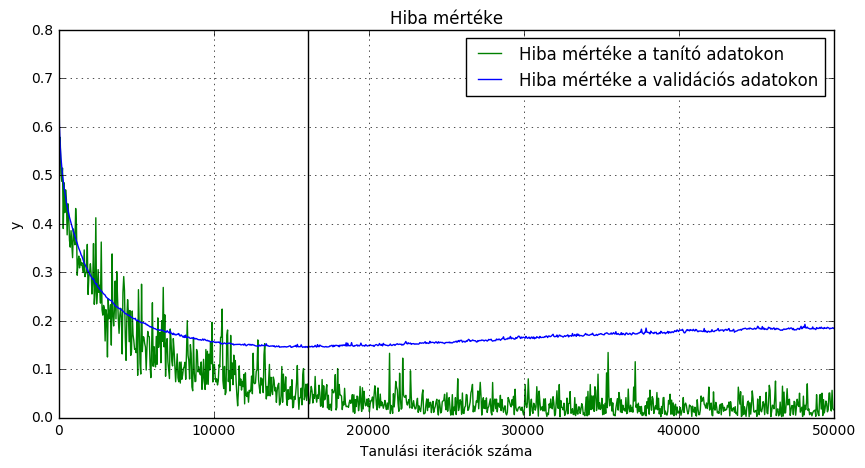

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 5))
plt.ylim(0, 0.8)
plt.title('Hiba mértéke')
plt.plot(np.arange(len(losses)) * 50, losses, color ='g', label='Hiba mértéke a tanító adatokon') 
plt.plot(np.arange(len(vlosses)) * 50, vlosses, color ='b', label='Hiba mértéke a validációs adatokon')
plt.axvline(x=eepoch, ymin=0., ymax=1., linewidth=1, color='k')
plt.legend(loc='upper right')
plt.xlabel('Tanulási iterációk száma')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [76]:
test_data = "Zsarnoki törvény és erkölcsi zsarnokság egyaránt nyomasztó."
# test_data = "A felújítás alatt álló épület tetőszerkezete beszakadt, és rázuhant a gyülekezetre."
# test_data = "Bizonyára méltóságteljes, hatalmas termetem indíthatta a gyermeket ilyen képzelettársításokra."
# test_data = "Változó korba kerültünk és ez külsőnkön is nyomot hagyott"
tmp = test_data.split(" ")
print(tmp)
test_x, test_y = prepare_words(tmp, 4, current_vowel)
# test_x = vectorizer.transform(tmp_x).toarray()

print(test_y)

['Zsarnoki', 'törvény', 'és', 'erkölcsi', 'zsarnokság', 'egyaránt', 'nyomasztó.']

[[0, 1], [0, 1], [1, 0], [1, 0]]


/home/zscseh93/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:79: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


In [77]:
result = sess.run(output, feed_dict={n_input: test_x})

result_list = []
for i in result:
    result_list.append(decide(i, current_vowel))

print(result_list)

[[0, 1], [0, 1], [1, 0], [1, 0]]
